In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.8 MB/s eta 0:00:00


In [3]:
import optuna

In [4]:
import pandas as pd
import numpy as np
import math


import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.layers import Bidirectional
from keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt

from joblib import Parallel
from joblib import delayed
from datetime import datetime

#import optuna

from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects
from keras.models import load_model

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu
from joblib import Parallel, delayed

import cProfile

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Multiply, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import SGD
import warnings
warnings.filterwarnings('ignore')

In [5]:
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])
dataset = dataset[['Rain','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']].reset_index()
s11 = pd.read_csv('/content/drive/Shareddrives/1st Paper/s11.csv', header = 0, infer_datetime_format=True, index_col=['TIMESTAMP']).drop('Unnamed: 0', axis=1).reset_index()

df = pd.concat([dataset, s11], axis = 1).set_index('Date Time')
df = df[['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]


In [8]:
def split_dataset(data):
  """
    Splits the dataset into train and test sets.

    Args:
        data (array): The dataset to be split.

    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  train, test = data[1:-6046], data[-6048:]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input, n_out=144):
  #flattern data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for i in range(len(data)):
    #define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    #ensure there is enough data
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return np.array(X), np.array(y)

def build_moe_model_with_autoencoder_cnn_attention(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts, learning_rate, activation, kernel_initializer, dropout_rate,
                                     num_iterations=2):
    """
    Builds a Mixture of Experts (MoE) model with autoencoder, CNN and attention mechanisms.

    Args:
        input_dim (int): The dimension of input features.
        output_dim (int): The dimension of output features.
        expert_hidden_sizes (list): The hidden layer sizes for each expert.
        expert_output_sizes (list): The output layer sizes for each expert.
        gating_hidden_sizes (list): The hidden layer sizes for the gating network.
        num_experts (int): The number of experts in the model.
        learning_rate (float): The learning rate for the optimizer.
        activation (str): The activation function to be used in the hidden layers.
        kernel_initializer (str): The kernel initializer for the layers.
        dropout_rate (float): The dropout rate for dropout layers.
        num_iterations (int, optional): The number of iterations for training. Defaults to 100.

    Returns:
        moe_model (Model): The Mixture of Experts model.
        experts (list): The list of expert models.
        gating_model (Model): The gating network model.
    """
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
            expert_hidden, _, _ = LSTM(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        elif i == 1:  # Replace second expert with a Transformer expert
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for Transformer input
            expert_hidden = MultiHeadAttention(num_heads=8, key_dim=expert_hidden_sizes[i])(expert_hidden, expert_hidden)
            expert_hidden = Flatten()(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        else:  # Replace third expert with a GRU-based model
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for GRU input
            expert_hidden, _ = GRU(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = Dense(gating_hidden_sizes[0], activation='relu', kernel_initializer='he_normal')(gating_input)
    gating_hidden = Dropout(dropout_rate)(gating_hidden)
    gating_hidden = tf.expand_dims(gating_hidden, axis=1)  # Expand dimensions for LSTM input
    gating_hidden = Bidirectional(LSTM(gating_hidden_sizes[1], return_sequences=False, kernel_initializer='he_normal'))(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)

    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output[:, :1] for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    """
    Defines the loss function for the Mixture of Experts (MoE) model.

    Args:
        y_true (tensor): The true target values.
        y_pred (tensor): The predicted target values.
        gating_output (tensor): The output of the gating network.

    Returns:
        (tensor): The calculated MoE loss.
    """
    y_true = tf.cast(y_true, y_pred.dtype)

    # Compute MAE instead of MSE
    expert_losses = tf.reduce_mean(tf.abs(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)

    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)

    # Multiply expert_losses with the gating probabilities
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)

    return tf.reduce_mean(gating_losses)

def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def nmse_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    variance = tf.math.reduce_variance(y_true)
    return mse / variance

def smape_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  denominator = (tf.abs(y_true) + tf.abs(y_pred)) + 1e-8
  return 2 * tf.reduce_mean(tf.abs(y_true - y_pred) / denominator)


def scheduler(epoch, lr):
    """
    Custom learning rate scheduler.

    Args:
        epoch (int): The current epoch.
        lr (float): The current learning rate.

    Returns:
        (float): The updated learning rate.
    """
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def sliding_window_split(data, window_size, step_size):
    """
    Splits the input data into sliding windows of specified size and step size.

    Args:
        data (array): The input data to be split.
        window_size (int): The size of the sliding window.
        step_size (int): The step size for sliding the window.

    Returns:
        windowed_data (list): A list of arrays containing the data split into sliding windows.
    """
    windowed_data = []
    for i in range(0, len(data) - window_size, step_size):
        windowed_data.append(data[i:i + window_size])
    return windowed_data
import os

def save_best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        # Save the best model
        best_model = trial.user_attrs['model']
        model_path = f'/content/drive/Shareddrives/1st Paper/Results_MoE/best_MoE_model_S11_improve_{trial.number}.h5'
        best_model.save(model_path)
        print(f"Best model saved to {model_path}")

In [9]:
def objective(trial, train_input, train_output, input_dim, output_dim):
    """ Objective function for hyper-paramter tuning. Read README file for further specifications.
    """
    # Define the hyperparameters to optimize using Optuna
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['glorot_normal', 'he_normal', None])

    window_size = 500
    step_size = 50

    # Define the sizes of the hidden layers for each expert
    expert_hidden_sizes = [16, 32, 64]

    # Define the sizes of the output layers for each expert
    expert_output_sizes = [144,144,144]

    # Define the sizes of the gating network hidden layers
    gating_hidden_sizes = [16, 8]

    # Define the size of the output layer of the gating network
    gating_output_size = num_experts

    # Define the number of training iterations for the EM algorithm
    num_iterations = 2 #change to 10

    df2 = df.copy()
    scaler = StandardScaler()

    # Fit and transform the data in the DataFrame
    standardized_data = scaler.fit_transform(df2)

    # Convert the result back to a DataFrame with the original column names
    s_df = pd.DataFrame(standardized_data, columns=df2.columns)
    train, test = split_dataset(df.values)
    s_train, s_test = split_dataset(s_df.values)
    #train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
    train_input_windows, _ = to_supervised(s_train, 144)

    _, train_output_windows = to_supervised(train, 144)
    train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
    train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])



    # Build and train the model using the hyperparameters
    moe_model, experts, gating_model = build_moe_model_with_autoencoder_cnn_attention(
        input_dim,
        output_dim,
        expert_hidden_sizes,
        expert_output_sizes,
        gating_hidden_sizes,
        num_experts,
        learning_rate,
        activation,
        kernel_initializer,
        dropout_rate)

    # Define the optimization algorithm
    optimizer = Adam(learning_rate=learning_rate)

    # Learning rate scheduler
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the MoE model with the EM algorithm
    iteration = 0
    while iteration < num_iterations:
        num_train_windows = int(0.8 * len(train_input_windows))
        total_train_loss = 0
        total_val_loss = 0
        for window_idx in range(len(train_input_windows)):

          # E step: Compute the responsibilities of each expert for each data point
          gating_output = tf.constant(gating_model.predict(train_input_windows[window_idx,:,:]), dtype=tf.float64)
          gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

          # M step: Update the parameters of each expert and the gating network
          for i in range(num_experts):
              expert_input = train_input_windows[window_idx,:,:]
              expert_output = experts[i](expert_input)
              expert_loss = tf.reduce_mean(tf.square(train_output_windows[window_idx,:,:] - expert_output), axis=-1)

              with tf.GradientTape() as tape:
                  # Watch the trainable variables of the expert model
                  tape.watch(experts[i].trainable_variables)

                  # Define the expert model and calculate the expert_loss
                  expert_output = experts[i](expert_input)
                  expert_loss = tf.reduce_mean(tf.square(train_output_windows[window_idx,:,:] - expert_output), axis=-1)

              # Compute the gradients
              expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
              # Clip gradients for expert models
              expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

              # Update the variables
              optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))

          current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
          optimizer.learning_rate.assign(current_learning_rate)

          gating_input = train_input_windows[window_idx,:,:]

          with tf.GradientTape() as tape:
              # Watch the trainable variables of the gating model
              tape.watch(gating_model.trainable_variables)

              # Define the gating model and calculate the gating_loss
              gating_output = gating_model(gating_input)
              gating_loss = moe_loss(tf.constant(train_output_windows[window_idx,:,:], dtype=tf.float32), moe_model(train_input_windows[window_idx,:,:]), gating_output)


          # Compute the gradients
          gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
          # Clip gradients for the gating model
          gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

          # Update the variables
          optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

          # Evaluate the performance of the MoE model on the training set
          if window_idx < num_train_windows:
            train_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            total_train_loss += train_loss
            print(f'Iteration {iteration + 1}, Training window {window_idx + 1}: Training loss = {train_loss:.6f}')
            train_mse = mse_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))
            train_nmse = nmse_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))
            train_smape = smape_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))

          else:
            val_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            total_val_loss += val_loss
            print(f'Iteration {iteration + 1}, Validation window {window_idx - num_train_windows + 1}: Validation loss = {val_loss:.6f}')
            val_mse = mse_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))
            val_nmse = nmse_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))
            val_smape = smape_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))


        # Stop training if the learning rate becomes too small
        if current_learning_rate < 1e-6:
            print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
            break

        iteration += 1
    trial.set_user_attr('model', moe_model)
    trial.set_user_attr('train_mse', train_mse)
    trial.set_user_attr('train_nmse', train_nmse)
    trial.set_user_attr('train_smape', train_smape)


    # Calculating the average train and validation loss
    avg_train_loss = total_train_loss / num_train_windows
    avg_val_loss = total_val_loss / (len(train_input_windows) - num_train_windows)


    # Store all the metrics you want to track
    trial.set_user_attr('train_mse', train_mse)
    trial.set_user_attr('train_nmse', train_nmse)
    trial.set_user_attr('train_smape', train_smape)
    trial.set_user_attr('avg_train_loss', avg_train_loss)
    trial.set_user_attr('avg_val_loss', avg_val_loss)
    trial.set_user_attr('val_mse', val_mse)
    trial.set_user_attr('val_nmse', val_nmse)
    trial.set_user_attr('val_smape', val_smape)

    # Return only the metric you're optimizing
    return avg_val_loss



In [ ]:
def split_dataset(data):
  """
    Splits the dataset into train and test sets.

    Args:
        data (array): The dataset to be split.

    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  #train, test = data[1:6769], data[6769:6769+(144*8)]
  train, test = data[1:2881], data[2881:2881+(144*8)]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test


In [ ]:
from functools import partial

#df = df.head(6191)

# Load the training data
train_data = np.array(df.head(10000))


# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

input_dim = df.shape[1]
output_dim = 1


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
train_input_windows, _ = to_supervised(s_train, 144)

_, train_output_windows = to_supervised(train, 144)
train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])


# Define the number of experts
num_experts = 3
objective_with_args = partial(objective, train_input=train_input, train_output=train_output, input_dim=input_dim, output_dim=output_dim)
study = optuna.create_study(direction="minimize")

study.optimize(objective_with_args, n_trials=3, callbacks=[save_best_model_callback]) #change to 5


completed_trials = study.trials_dataframe(attrs=('number', 'value', 'params', 'user_attrs'))
print(completed_trials[['number', 'value', 'user_attrs_train_mse', 'user_attrs_train_nmse', 'user_attrs_train_smape',
                        'user_attrs_avg_train_loss', 'user_attrs_avg_val_loss', 'user_attrs_val_mse', 'user_attrs_val_nmse', 'user_attrs_val_smape']])

[I 2023-08-25 23:19:08,225] A new study created in memory with name: no-name-06eaa5b5-db5f-4bcd-b436-781952bf2149


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 4ms/step
Iteration 1, Training window 5741: Training loss = 9.397229
5/5 [==============================] - 0s 4ms/step
Iteration 1, Training window 5742: Training loss = 9.397358
5/5 [==============================] - 0s 5ms/step
Iteration 1, Training window 5743: Training loss = 9.309350
5/5 [==============================] - 0s 4ms/step
Iteration 1, Training window 5744: Training loss = 9.270776
5/5 [==============================] - 0s 4ms/step
Iteration 1, Training window 5745: Training loss = 9.206923
5/5 [==============================] - 0s 4ms/step
Iteration 1, Training window 5746: Training loss = 9.185198
5/5 [==============================] - 0s 4ms/step
Iteration 1, Training window 5747: Training loss = 9.090548
5/5 [==============================] - 0s 5ms/step
Iteration 1, Training window 5748: Training loss = 9.032879
5/5 [==============================] - 0s 4ms/step
Iteration 

In [ ]:
completed_trials = study.trials_dataframe(attrs=('number', 'value', 'params', 'user_attrs'))
print(completed_trials[['number', 'value', 'user_attrs_train_mse', 'user_attrs_train_nmse', 'user_attrs_train_smape',
                        'user_attrs_avg_train_loss', 'user_attrs_avg_val_loss', 'user_attrs_val_mse', 'user_attrs_val_nmse', 'user_attrs_val_smape']])

   number     value                               user_attrs_train_mse  \
0       0  5.641573  tf.Tensor(12.822540497991863, shape=(), dtype=...   
1       1  4.729951  tf.Tensor(4.503372798237291, shape=(), dtype=f...   
2       2  5.981085  tf.Tensor(18.410204623498306, shape=(), dtype=...   

                               user_attrs_train_nmse  \
0  tf.Tensor(1.0381862199727594, shape=(), dtype=...   
1  tf.Tensor(0.3646188197465491, shape=(), dtype=...   
2  tf.Tensor(1.490595467410537, shape=(), dtype=f...   

                          user_attrs_train_smape  \
0  tf.Tensor(0.4322637, shape=(), dtype=float32)   
1  tf.Tensor(0.2880875, shape=(), dtype=float32)   
2  tf.Tensor(0.5087625, shape=(), dtype=float32)   

                       user_attrs_avg_train_loss  \
0   tf.Tensor(3.740565, shape=(), dtype=float32)   
1  tf.Tensor(2.2727883, shape=(), dtype=float32)   
2   tf.Tensor(4.525426, shape=(), dtype=float32)   

                         user_attrs_avg_val_loss  \
0  tf.Te

In [ ]:
from tensorflow.keras.models import load_model

# Assuming the best model was saved with filename 'best_model.h5'
moe_model = load_model('/content/drive/Shareddrives/1st Paper/Results_MoE/best_MoE_model_S11_1.h5')
df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
test_input_windows, _ = to_supervised(s_test, 144)

_, test_output_windows = to_supervised(test, 144)
test_output_windows = np.array([[item] for item in test_output_windows[:][:]])
test_output_windows = test_output_windows.reshape(test_output_windows.shape[0],test_output_windows.shape[2], test_output_windows.shape[1])


pred = []
mae_l = []
mse_l = []
nmse_l = []
smape_l = []
i = 0
for window_idx in range(len(test_input_windows)):
  # Evaluate the model on the test data
  predictions = moe_model.predict(test_input_windows[window_idx], verbose = 0)
  pred.append(predictions)
  mae = mean_absolute_error(test_output_windows[i], predictions)
  mae_l.append(mae)
  mse = mean_squared_error(test_output_windows[i], predictions)
  mse_l.append(mse)
  nmse = nmse_loss(test_output_windows[i], predictions)
  nmse_l.append(nmse)
  smape = smape_loss(test_output_windows[i], predictions)
  smape_l.append(smape)
  i = i + 1



In [ ]:
print('mae', np.mean(mae_l), 'mse', np.mean(mse_l), 'nmse',np.mean(nmse_l), 'smape', np.mean(smape_l))

mae 2.7495439188751822 mse 23.72926559759271 nmse 2.5725498440037207 smape 0.34217554


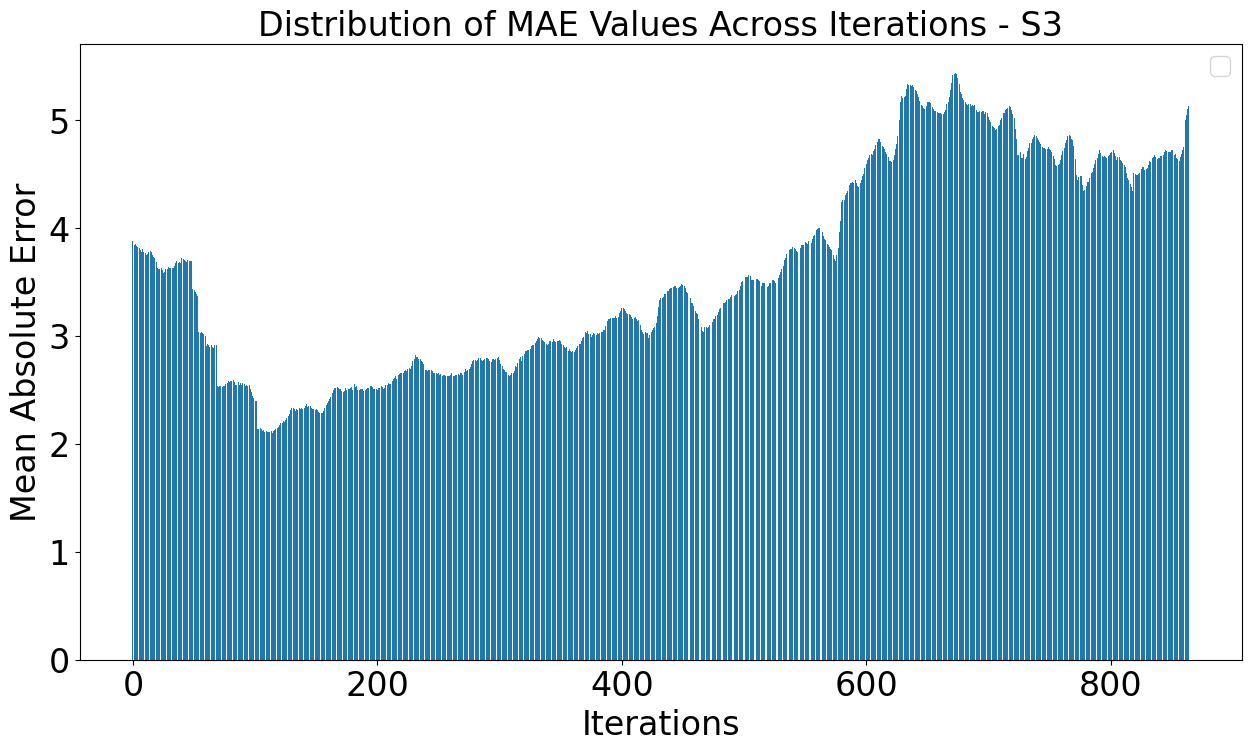

In [ ]:

a = pd.DataFrame(mae_l).reset_index()
a.columns = ['iterations', 'value']
a.to_excel('/content/drive/Shareddrives/1st Paper/Results_MoE/TestS11MoE.xlsx', index=False)




# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.bar(a['iterations'], a['value'])

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Iterations', fontsize=axis_font_size)
plt.ylabel('Mean Absolute Error', fontsize=axis_font_size)
plt.title('Distribution of MAE Values Across Iterations - S3', fontsize = 24)


# Display the plot
plt.show()

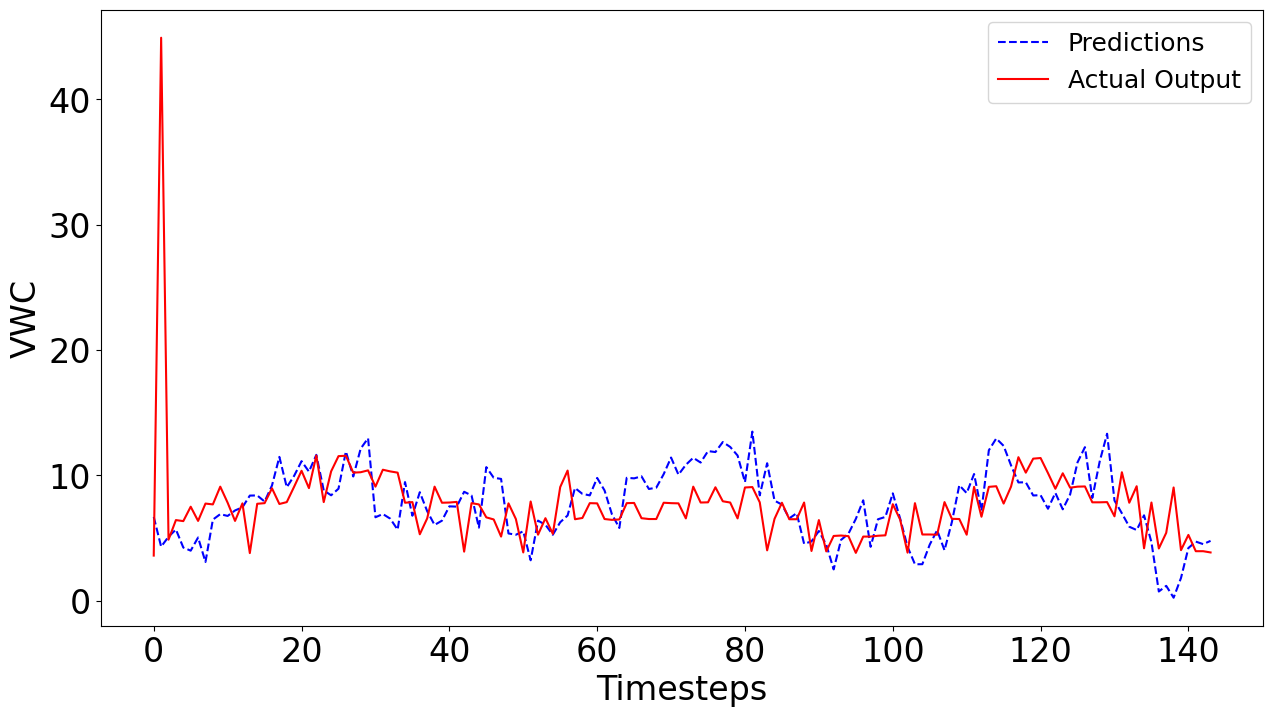

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k =100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size, loc='upper right')

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

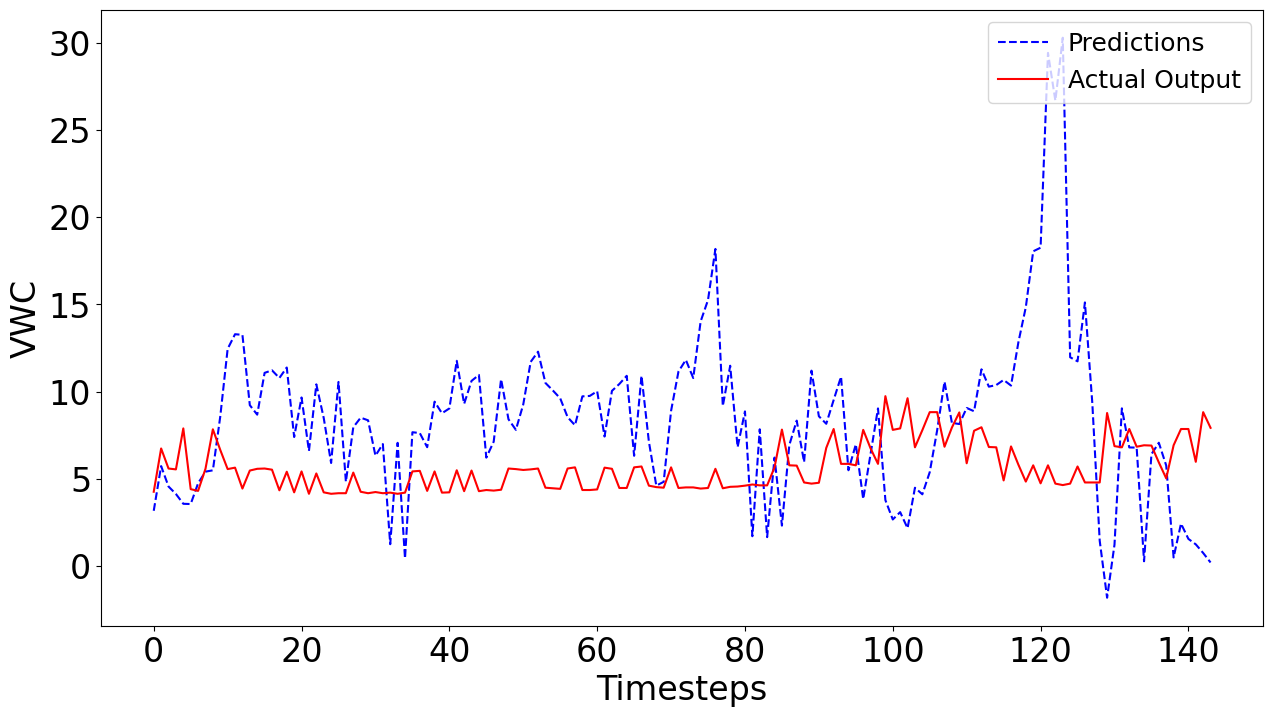

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 600
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size, loc='upper right')

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

**Individual models deployment**

In [ ]:
  # dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
  # learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])
  # kernel_initializer = trial.suggest_categorical('kernel_initializer', ['glorot_normal', 'he_normal', None])

window_size = 500
step_size = 50



In [ ]:
num_experts = 3

input_dim = df.shape[1]
output_dim = 1

def create_train_expert_model(i, input_dim, output_dim, X_train, y_train, X_test, y_test, activation,
                              kernel_initializer, dropout_rate):

    # Define the sizes of the hidden layers for each expert
    expert_hidden_sizes = [16, 32, 64]

    # Define the sizes of the output layers for each expert
    expert_output_sizes = [144,144,144]

    # Define the sizes of the gating network hidden layers
    gating_hidden_sizes = [16, 8]

    # Define the size of the output layer of the gating network
    gating_output_size = num_experts

    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
            expert_hidden, _, _ = LSTM(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        elif i == 1:  # Replace second expert with a Transformer expert
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for Transformer input
            expert_hidden = MultiHeadAttention(num_heads=8, key_dim=expert_hidden_sizes[i])(expert_hidden, expert_hidden)
            expert_hidden = Flatten()(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        else:  # Replace third expert with a GRU-based model
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for GRU input
            expert_hidden, _ = GRU(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Train each expert model
    if i == 0:  # Autoencoder
        expert_model = Model(inputs=experts[0].input, outputs=experts[0].output)
    elif i == 1:  # CNN
        expert_model = Model(inputs=experts[1].input, outputs=experts[1].output)
    else:  # Attention-based model
        expert_model = Model(inputs=experts[2].input, outputs=experts[2].output)

    expert_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error', metrics=['mse'])
    expert_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), verbose=0)

    return expert_model

def objective(trial):
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['he_normal', 'lecun_normal'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    num_train_windows = int(0.8 * len(train_input_windows))
    total_train_loss = 0
    total_val_loss = 0
    for window_idx in range(len(train_input_windows)):
      expert_model = create_train_expert_model(i, input_dim, output_dim, train_input_windows[window_idx], train_output_windows[window_idx], test_input_windows[window_idx],
                                               test_output_windows[window_idx], activation, kernel_initializer, dropout_rate)
      loss, mae = expert_model.evaluate(test_input_windows[window_idx], test_output_windows[window_idx], verbose=0)

    return mae

study = optuna.create_study(direction='minimize')
for i in range(num_experts):
    study.optimize(objective, n_trials=1)
    best_params = study.best_params
    print(f"Best parameters for expert {i}: {best_params}")

    expert_model = create_train_expert_model(i, input_dim, output_dim, train_input, train_output, test_input, test_output, best_params['activation'], best_params['kernel_initializer'], best_params['dropout_rate'])
    experts[i] = expert_model
# Evaluate the individual expert models
for i, expert_model in enumerate(experts):
    expert_predictions = expert_model.predict(test_input)
    print(expert_predictions[0:10])
    expert_mae = mean_absolute_error(test_output, expert_predictions[:,0].T.reshape(100,1))
    expert_mse = mean_squared_error(test_output, expert_predictions[:,0].T.reshape(100,1))
    print(f"Expert {i} model performance: MAE={expert_mae}, MSE={expert_mse}")

[I 2023-08-14 06:16:13,575] A new study created in memory with name: no-name-95edb053-dcb3-4e60-a91c-994bc0237493
[W 2023-08-14 06:16:13,581] Trial 0 failed with parameters: {'activation': 'tanh', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.4531458256017845} because of the following error: NameError("name 'train_input' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-20-b61f895a197a>", line 25, in objective
    expert_model = create_train_expert_model(i, input_dim, output_dim, train_input, train_output, test_input, test_output, activation, kernel_initializer, dropout_rate)
NameError: name 'train_input' is not defined
[W 2023-08-14 06:16:13,590] Trial 0 failed with value None.


NameError: ignored